# Определение возраста по фото

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Имеем 7591 размеченное фото (наверное для публичного датасета это приличное количество), из которых сформируем тренировочную (5694 фото) и валидационную выборки(1897 фото).

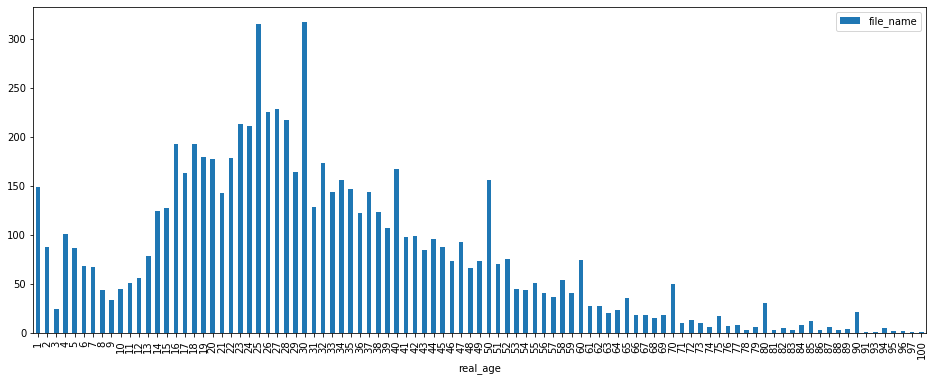

In [3]:
labels_pivot = labels.pivot_table(values='file_name', index='real_age', aggfunc='count')
labels_pivot.plot(kind='bar', figsize=(16, 6))

+ Распределение двумодальное. Это может быть связано с тем что датасет является сборным из нескольких (судя по его описанию так оно и есть), а также с особенностями поведения людей (например родители часто публикуют фото своих новорожденных детей, люди старшего возраста реже публикуют свои фото и т.п.).
+ Наблюдаются пики приходящиеся на круглые даты:30, 40, 50 и т.д. лет (опять же особенности поведения людей).
+ Центральная часть напоминает нормальное распределение.
+ В связи с неравномерным распределением, можно ожидать, что точность определения в разных возрастных категориях будет разниться.

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
                    dataframe=labels,
                    directory='/datasets/faces/final_files/',
                    x_col='file_name',
                    y_col='real_age',
                    target_size=(224, 224),
                    batch_size=32,
                    class_mode='raw',
                    seed=12345)

Found 7591 validated image filenames.


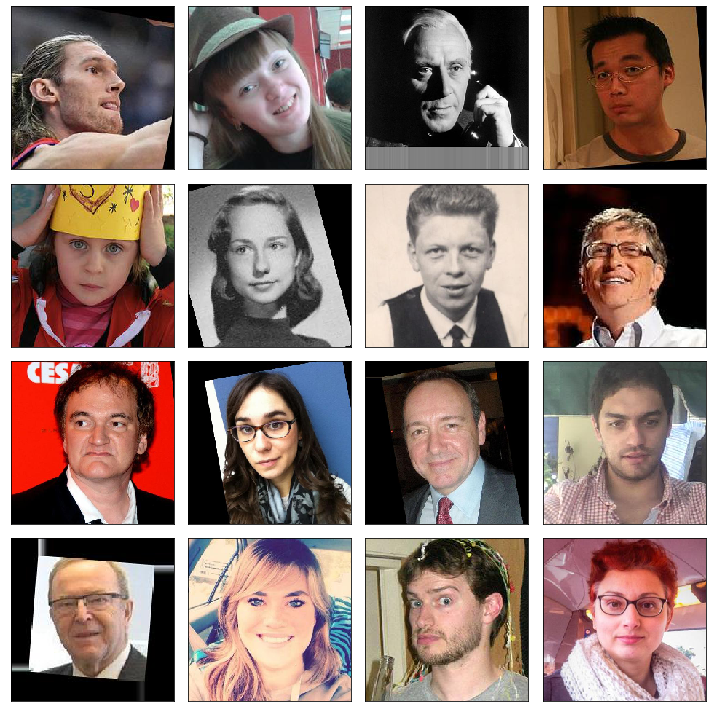

In [12]:
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете присутствует много знаменитостей. Квентин Тарантино и Кевин Спэйси встретились в одном батче.

# 2. Обучение модели

(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

labels = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):

    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255.,
        validation_split=0.25)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):

    test_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps

Epoch 1/10
178/178 - 117s - loss: 266.7548 - mae: 11.8899 - val_loss: 780.8639 - val_mae: 23.0253
Epoch 2/10
178/178 - 40s - loss: 106.6971 - mae: 7.7405 - val_loss: 843.5859 - val_mae: 24.1327
Epoch 3/10
178/178 - 39s - loss: 82.1245 - mae: 6.8900 - val_loss: 236.4620 - val_mae: 11.6119
Epoch 4/10
178/178 - 39s - loss: 65.6567 - mae: 6.1201 - val_loss: 118.3490 - val_mae: 8.4175
Epoch 5/10
178/178 - 39s - loss: 52.0649 - mae: 5.4901 - val_loss: 87.2460 - val_mae: 7.1579
Epoch 6/10
178/178 - 39s - loss: 45.3859 - mae: 5.1218 - val_loss: 113.5142 - val_mae: 8.2743
Epoch 7/10
178/178 - 40s - loss: 38.3907 - mae: 4.7215 - val_loss: 114.3475 - val_mae: 8.6094
Epoch 8/10
178/178 - 40s - loss: 33.3752 - mae: 4.3862 - val_loss: 69.6817 - val_mae: 6.3509
Epoch 9/10
178/178 - 40s - loss: 29.5497 - mae: 4.1340 - val_loss: 75.9343 - val_mae: 6.4819
Epoch 10/10
178/178 - 40s - loss: 27.6750 - mae: 3.9948 - val_loss: 76.0310 - val_mae: 6.5605

60/60 - 10s - loss: 76.0310 - mae: 6.5605
Test MAE: 6.5605

```

# 3. Анализ обученной модели

+ Поскольку решалась задача регрессии, то в финальном слое нейросети ставится один нейрон.
+ С каждой эпохой на тренировочной выборке MAE планомерно уменьшается. На валидационной выборке в целом тоже уменьшается, но уже имеются локальные минимумы и максимумы.
+ Итоговое значение метрики MAE составило 6.56 лет. Мне кажется практическое применение такой модели невозможно.